In [1]:
import numpy as np
import pandas as pd
# import openai
# from openai.embeddings_utils import get_embedding
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm, trange
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
path = 'data/fine-food-reviews/Reviews.csv'

In [3]:
df = pd.read_csv(path)
df = df[:10000]

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
sample = df.Text[0]
sample

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [6]:
df.Score = df.Score - 1

In [7]:
df = df.drop(df.columns.difference(['Text', 'Score']), axis=1)

In [8]:
train_df = df.sample(frac=0.6)
val_df = df.drop(train_df.index).sample(frac=0.25)
test_df = df.drop(train_df.index).drop(val_df.index)

In [9]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

100%|██████████| 10000/10000 [00:00<00:00, 191182.89it/s]


(array([9.135e+03, 7.230e+02, 9.800e+01, 2.700e+01, 7.000e+00, 6.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  10. ,  160.3,  310.6,  460.9,  611.2,  761.5,  911.8, 1062.1,
        1212.4, 1362.7, 1513. ]),
 <BarContainer object of 10 artists>)

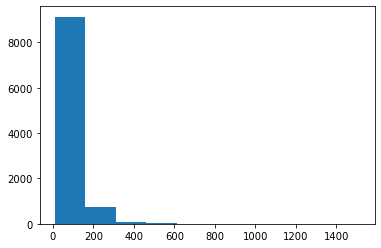

In [10]:
lens = []
for text in tqdm(df.Text):
    lens.append(len(text.split()))

plt.hist(lens)

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [12]:
tokenizer.encode_plus(sample, add_special_tokens=True)

{'input_ids': [101, 1045, 2031, 4149, 2195, 1997, 1996, 8995, 3012, 27141, 3899, 2833, 3688, 1998, 2031, 2179, 2068, 2035, 2000, 2022, 1997, 2204, 3737, 1012, 1996, 4031, 3504, 2062, 2066, 1037, 20717, 2084, 1037, 13995, 6240, 1998, 2009, 14747, 2488, 1012, 2026, 18604, 2003, 10346, 6799, 2100, 1998, 2016, 9120, 2015, 2023, 4031, 2488, 2084, 2087, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
train_input_ids = []
train_attention_masks = []

for text in tqdm(train_df.Text):
    tok = tokenizer.encode_plus(text, add_special_tokens=True, max_length=256, pad_to_max_length=True, truncation=True, return_attention_mask=True, return_tensors='pt')
    train_input_ids.append(tok['input_ids'])
    train_attention_masks.append(tok['attention_mask'])

train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_df.Score)

  0%|          | 0/6000 [00:00<?, ?it/s]c:\Users\Shaz\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 6000/6000 [00:11<00:00, 506.12it/s]


In [14]:
val_input_ids = []
val_attention_masks = []

for text in tqdm(val_df.Text):
    tok = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, pad_to_max_length=True, truncation=True, return_attention_mask=True, return_tensors='pt')
    val_input_ids.append(tok['input_ids'])
    val_attention_masks.append(tok['attention_mask'])

val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_df.Score)

100%|██████████| 1000/1000 [00:01<00:00, 514.59it/s]


In [15]:
test_input_ids = []
test_attention_masks = []

for text in tqdm(test_df.Text):
    tok = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, pad_to_max_length=True, truncation=True, return_attention_mask=True, return_tensors='pt')
    test_input_ids.append(tok['input_ids'])
    test_attention_masks.append(tok['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_df.Score)

100%|██████████| 3000/3000 [00:05<00:00, 585.37it/s]


In [16]:
batch_size = 8

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [17]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('CPU')

GPU:  NVIDIA GeForce RTX 3060 Laptop GPU


In [19]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
if device.type == 'cuda':
    model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
lr = 1e-6
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

c:\Users\Shaz\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
epochs = 5

In [23]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

for epoch_i in range(epochs):
    print()
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    total_train_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    

    print()
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print()
    print("Running Validation...")

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in tqdm(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # training_stats.append(
    #     {
    #         'epoch': epoch_i + 1,
    #         'Training Loss': avg_train_loss,
    #         'Valid. Loss': avg_val_loss,
    #         'Valid. Accur.': avg_val_accuracy,
    #         'Training Time': training_time,
    #         'Validation Time': validation_time
    #     }
    # )

print("")
print("Training complete!")


======== Epoch 1 / 5 ========


100%|██████████| 750/750 [02:50<00:00,  4.39it/s]



  Average training loss: 1.26

Running Validation...


100%|██████████| 125/125 [00:17<00:00,  6.99it/s]


  Accuracy: 0.62
  Validation Loss: 1.10

======== Epoch 2 / 5 ========


100%|██████████| 750/750 [02:50<00:00,  4.40it/s]



  Average training loss: 1.02

Running Validation...


100%|██████████| 125/125 [00:17<00:00,  6.98it/s]


  Accuracy: 0.64
  Validation Loss: 0.91

======== Epoch 3 / 5 ========


100%|██████████| 750/750 [02:50<00:00,  4.39it/s]



  Average training loss: 0.90

Running Validation...


100%|██████████| 125/125 [00:18<00:00,  6.85it/s]


  Accuracy: 0.69
  Validation Loss: 0.83

======== Epoch 4 / 5 ========


100%|██████████| 750/750 [02:51<00:00,  4.37it/s]



  Average training loss: 0.83

Running Validation...


100%|██████████| 125/125 [00:18<00:00,  6.75it/s]


  Accuracy: 0.72
  Validation Loss: 0.77

======== Epoch 5 / 5 ========


100%|██████████| 750/750 [02:57<00:00,  4.23it/s]



  Average training loss: 0.77

Running Validation...


100%|██████████| 125/125 [00:18<00:00,  6.74it/s]

  Accuracy: 0.74
  Validation Loss: 0.74

Training complete!
